## 1. Introduction
Objective code taken from https://github.com/abe-mart/alphaopt/blob/master/Snowball%20Optimization/Python%20Version/snowball.py
Paper: "Comparative kinetics of the snowball respect to other dynamical objects" (2013, Rodolfo A. Diaz et al.)

Objective: Find the minimal mass of the initial snowball to roll down the hill and strike the tree with enough force. 25000 Newton needed to strike down the tree. Consider: snowball growth, gravity, air density, mass, force, etc.

## 2.

### 2.1 Define task and black-box

In [1]:
import os
plot_path = 'plots/'
if not os.path.exists(plot_path):
    os.makedirs(plot_path)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 7
         Function evaluations: 27
         Gradient evaluations: 9
Initial Mass: 46.51960081989454 kg (93.96959365618697 lbs)
Initial Radius: 31.65870226849633 cm (12.464031083107004 inches)
Final Force: 22345.755524150416
Final Position: 219.47582030729484
Final Velocity: 14.13658179017689


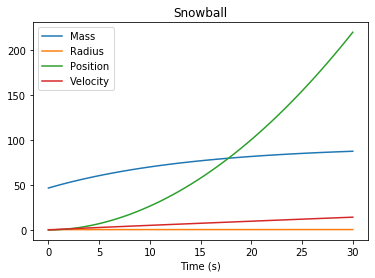

In [2]:
# -*- coding: utf-8 -*-

import numpy as np # General numerics
from scipy.integrate import odeint # Integration
from scipy.optimize import minimize # Optimization
import matplotlib.pyplot as plt # Plotting

# Define System Parameters
K0 = 85 # Snowball growth factor 1
beta = 0.07 # Snowball growth factor 2
C_d = 0.3 # Drag coefficient
g = 9.8 # Gravity
rho = 350 # Snow density
theta = np.radians(5) # Slope
rho_a = 0.9 # Air density

# Initial Snowball Conditions
m0 = 10 # Initial mass
v0 = 0 # Initial velocity
r0 = (m0/(4/3.0*np.pi*rho))**(1/3.0) # Initial radius
s0 = 0 # Initial position

# Target force
F_d = 25000

# Set up time array to solve for 30 seconds
t = np.linspace(0,30)

# This function defines the dynamics of our snowball, the equations of motion
# and the rate at which it changes size and mass.
def snowball_dynamics(w,t,p):
    
    # unpack state variables
    M,r,s,v = w
    
    # unpack parameters
    K0,C_d,g,rho,theta,rho_a,beta = p
    
    # Make an array of the right hand sides of the four differential equations that make up our system.
    f = [beta * K0 * np.exp(-beta*t),
         (beta * K0 * np.exp(-beta*t))/(4*np.pi*rho*r**2),
         v,
         (-15*rho_a*C_d)/(56*rho)*1/r*v**2 - 23/7*1/r*beta*K0*np.exp(-beta*t)/(4*np.pi*rho*r**2)*v+5/7*g*np.sin(theta)]
    return f

# This is the objective function of our optimization.  The optimizer will attempt
# to minimize the output of this function by changing the initial snowball mass.
def objective(m0):
    
    # Load parameters
    p = [K0,C_d,g,rho,theta,rho_a,beta]
    
    # Get initial radius from initial mass
    r0 = (m0/(4/3.0*np.pi*rho))**(1/3.0)
    
    # Set initial guesses
    w0 = [m0,r0,s0,v0]
    
    # Integrate forward for 60 seconds
    sol = odeint(snowball_dynamics,w0,t,args=(p,))
    
    # Calculate kinetic energy at the end of the run
    ke = 0.5 * sol[:,0][-1] * sol[:,3][-1]**2

    # Calculate force required to stop snowball in one snowball radius
    F = ke / sol[:,1][-1]
    
    # Compare to desired force : This should equal zero when we are done
    obj = (F - F_d)**2
    
    return obj

# Call optimization using the functions defined above
res = minimize(objective,m0,options={'disp':True},)    

# Get optimized initial mass from solution
m0_opt = res.x[0]

# Calculate optimized initial radius from initial mass
r0_opt = (m0_opt/(4/3.0*np.pi*rho))**(1/3.0)

print('Initial Mass: ' + str(m0_opt) + ' kg (' + str(m0_opt*2.02) + ' lbs)')
print('Initial Radius: ' + str(r0_opt*100) + ' cm (' + str(r0_opt*39.37) + ' inches)')

# Just to prove to ourselves that the answer is correct, let's calculate
# the final force using the optimized initial conditions

# Set initial conditions
w0 = [m0_opt,r0_opt,s0,v0]

# Load parameters
p = [m0_opt,C_d,g,rho,theta,rho_a,beta]

# Integrate forward
sol = odeint(snowball_dynamics,w0,t,args=(p,))

# Get kinetic energy
ke = 0.5 * sol[:,0][-1] * sol[:,3][-1]**2

# Get final stopping force
F = ke / sol[:,1][-1]
print('Final Force: ' + str(F))

# Final Position
print('Final Position: ' + str(sol[:,2][-1]))
print('Final Velocity: ' + str(sol[:,3][-1]))

# And some plots of the results
plt.figure()
plt.plot(t,sol[:,0],label='Mass')
plt.plot(t,sol[:,1],label='Radius')
plt.plot(t,sol[:,2],label='Position')
plt.plot(t,sol[:,3],label='Velocity')
plt.title('Snowball')
plt.xlabel('Time (s)')
plt.legend()

### 2.2. Plot of objective

In [3]:
xn = np.linspace(1, 100, 1000)
yn = np.array(list(map(objective, xn)))

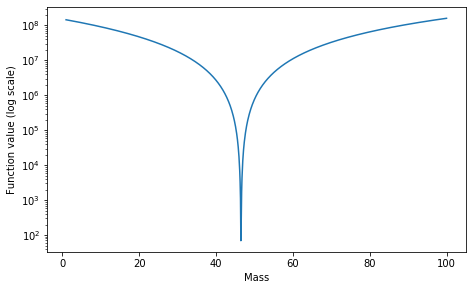

In [4]:
plt.figure(figsize=(7.5, 4.5))
plt.plot(xn, yn)#, s=1)
plt.yscale('log')
plt.xlabel('Mass')
plt.ylabel('Function value (log scale)')

plot_filepath = plot_path+'objective.pdf'
plt.savefig(plot_filepath, bbox_inches='tight')
# plt.legend()

## 3. Find optimal initial weight to strike down tree with grAdapt

In [5]:
# grAdapt
import grAdapt
from grAdapt.space.datatype import Float
from grAdapt.models import Sequential
from grAdapt.optimizer import AMSGradBisection
from grAdapt.surrogate import GPRSlidingWindow

In [6]:
n_evals = 1000
mass = Float(1, 100)
bounds = [mass]

In [7]:
surrogate = GPRSlidingWindow()
optimizer = AMSGradBisection(surrogate=surrogate)
model = Sequential(surrogate=surrogate, optimizer=optimizer, random_state=1)
res = model.minimize(objective, bounds, n_evals)

  6%|████▋                                                                          | 59/1000 [00:00<00:01, 553.74it/s]

Sampling 153 random points.
Random function evaluations. This might take a while.


 16%|████████████▍                                                                  | 157/1000 [00:00<00:21, 38.97it/s]

Finding optimum...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:25<00:00, 38.92it/s]


### 3.1. Optimal snowball mass (grAdapt vs scipy)

In [8]:
# grAdapt solution
res['x_sol']

array([46.52086848])

In [9]:
np.argmax(res['x'] == res['x_sol'])

701

In [10]:
# scipy solution
m0_opt

46.51960081989454

### 3.2. Plot snowball mass overtime

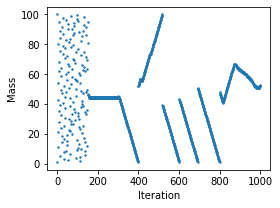

In [11]:
plt.figure(figsize=(4,3))
plt.scatter(np.arange(len(res['x'])), res['x'], s=2)
plt.ylabel('Mass')
plt.xlabel('Iteration')

plot_filepath = plot_path+'mass_iteration.pdf'
plt.savefig(plot_filepath, bbox_inches='tight')

### 3.3. Plot Training Loss

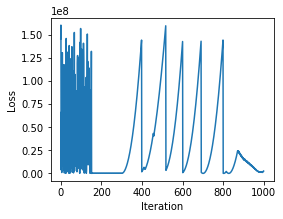

In [12]:
plt.figure(figsize=(4,3))
plt.plot(res['y'])
plt.ylabel('Loss')
plt.xlabel('Iteration')
#plt.yscale('log')

plot_filepath = plot_path+'loss_iteration.pdf'
plt.savefig(plot_filepath, bbox_inches='tight')

### 3.4. Loss comparison (grAdapt vs scipy)

In [13]:
# grAdapt
objective(res['x_sol'])

0.10113090475424588

In [14]:
m0_opt

46.51960081989454

In [15]:
res['x_sol']

array([46.52086848])

In [16]:
# scipy
objective(m0_opt)

3.5001432618494765e-12

In [17]:
np.abs(res['x_sol']-m0_opt)

array([0.00126766])